In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import animation, rc
# from IPython.display import HTML, Image
import datetime
import math
# import sys
# import os
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.metrics import confusion_matrix

In [ ]:
#Initializations
path = './reviews_Digital_Music_5.json/Music_Review_train.json'
test_path = './reviews_Digital_Music_5.json/Music_Review_test.json'
data = None
vocab = set()
ps = PorterStemmer()
class_size = 4
stop_words = stopwords.words('english')
table = str.maketrans('', '', string.punctuation)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/harsh/nltk_data'
    - '/home/harsh/anaconda3/nltk_data'
    - '/home/harsh/anaconda3/share/nltk_data'
    - '/home/harsh/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [6]:
def read_it(path):
    data = {}
    with open(path) as f:
        i =0
        for l in f:
            data[i] = eval(l)
            i += 1
    return pd.DataFrame.from_dict(data, orient='index')

In [7]:
data = read_it(path)
print(data.shape)

(50000, 9)


In [8]:
#remove later
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AKFE1P1ZDBPXU,B000002IWQ,"M. B. Link ""wildfirelink""","[4, 5]",Counterparts(1993). Rush's fifteenth studio al...,4.0,Underrated and Overrated Simultaneously,1067904000,"11 4, 2003"
1,A10CBLMJD1OQL7,B000002IWQ,mcmahonryan@hotmail.com,"[0, 0]","You have to ask yourself why, in 1998, there a...",4.0,Rush continues to reinvent itself,900633600,"07 17, 1998"
2,A331OF34UX4Y1K,B000002IWQ,"M. Fonseca ""carmarthen""","[2, 9]",I've bought this CD a long time ago and until ...,2.0,THE WEAKEST RUSH ALBUM EVER !,944006400,"12 1, 1999"
3,A18IZ5QX2PRB3C,B000002IWQ,Michael Stack,"[80, 83]","I am often in the minority in my view of this,...",5.0,Rush's '90s masterpiece.,1111536000,"03 23, 2005"
4,A2H22I2RWE0HOV,B000002IWQ,Mr. Sinister,"[3, 6]",The first thing that becomes apparent as soon ...,4.0,Counterparts Shifts The Rush Sound Once Again,1184025600,"07 10, 2007"


In [9]:
# import nltk
# nltk.download('punkt')
#nltk.download('stopwords')

In [10]:
def tokenize(review_string, stop_words= stop_words, table = table):
    tokens = word_tokenize(review_string)
    tokens = [token.lower() for token in tokens]
    #tokens = [token.translate(table) for token in tokens]## change it back
    words = [token for token in tokens if token.isalpha() and len(token)>=1] ## check with >= 1 as well
    #words = [ps.stem(word) for word in words if not word in stop_words]
    return words

In [11]:
term_dict_by_class = {}
docs_in_class = {} 
t1 = datetime.datetime.now()
def make_term_dict():
    global vocab
    global stop_words
    reviews_by_class = {}
    term_dict_by_class = {}
    
    table = str.maketrans('', '', string.punctuation)
    
    for review, label in zip(data['reviewText'],data['overall']):
        words = tokenize(review, stop_words, table)
        
        ##Counting the docs in respective class
        if label not in docs_in_class:
            docs_in_class[label]=0
        docs_in_class[label] += 1
        
        for word in words:
            if label not in term_dict_by_class:
                term_dict_by_class[label] = {}
            if word not in term_dict_by_class[label]:
                term_dict_by_class[label][word] = 0
            #print(word, end="-")
            term_dict_by_class[label][word] += 1
        
        if label not in reviews_by_class:
            reviews_by_class[label] = []
        reviews_by_class[label].append(words)
        
        vocab = vocab | set(words)
        #print(term_dict_by_class)
        
    return term_dict_by_class
term_dict_by_class = make_term_dict()
t2 = datetime.datetime.now()
print('Time Taken to make Term Dictionary:', t2 - t1)

Time Taken to make Term Dictionary: 0:04:43.068963


In [12]:
print(set(term_dict_by_class))
for d in docs_in_class:
    print(d, docs_in_class[d])

{1.0, 2.0, 3.0, 4.0, 5.0}
4.0 13267
2.0 2638
5.0 25932
1.0 2529
3.0 5634


In [13]:
print(len(vocab))

90061


In [34]:
from random import seed
from random import randint
class NaiveBayes:
    
    def __init__(self):
        self.theta = {}
        self.prior = {}
        self.class_labels = []
        self.freq_count = {}
        self.alpha = 1
    
    def model_parameters(self, term_dict_by_class, docs_in_class, alpha):
        theta = {}
        prior = {}
        self.alpha = alpha
        total_docs = 0
        #class_labels = [1.0, 2.0, 3.0, 4.0, 5.0]
        self.class_labels = list(set(term_dict_by_class))
        for k in self.class_labels:
            #Counting total documents
            total_docs += docs_in_class[k]
            
            #Calculating frequency for each term of a class_label
            self.freq_count[k] = 0
            for term in vocab:
                if term in term_dict_by_class[k]:
                    self.freq_count[k] += term_dict_by_class[k][term]
        
        #Calculating Thetas
        for k in self.class_labels:
            theta[k] = {}
            for term in vocab:
                if term in term_dict_by_class[k]:
                    theta[k][term] = term_dict_by_class[k][term] + alpha
                    theta[k][term] = math.log(theta[k][term]) - math.log(self.freq_count[k] + alpha*len(vocab))
                else:
                    theta[k][term] = math.log(alpha) - math.log(self.freq_count[k] + alpha*len(vocab))
        
        #Calculating Priors
        for k in self.class_labels:
            prior[k] = math.log(docs_in_class[k]/total_docs)

        print('theta shape',len(theta))
        print('prior:', prior)
        return theta, prior
    
    def learn(self, term_dict_by_class,docs_in_class, alpha):
        self.theta, self.prior = self.model_parameters(term_dict_by_class,docs_in_class, alpha)
        return self.theta, self.prior
    
    def calc_accuracy(self, predictions, labels):
        correct = 0
        for p,l in zip(predictions, labels):
            if( p == l):
                correct +=1
        return correct*100/len(predictions)
    
    def predict(self, reviews, labels=[]):
        table = str.maketrans('', '', string.punctuation)
        overall_ratings = []*len(reviews)
        result = [{}]*len(reviews)
        final_result = []
        for review,i in zip(reviews, range(len(reviews))):
            
            words = tokenize(review, stop_words, table)
            
            for k in self.class_labels:
                result[i][k] = self.prior[k]
                for word in words:
                    #Handling new words in test case
                    if word in self.theta[k]:
                        result[i][k] += self.theta[k][word]
                    else:
                        result[i][k] += math.log(self.alpha/(self.freq_count[k] + self.alpha*len(vocab)))
            
            max_result_val = result[i][1.0]
            final_class = 1.0
            for k in self.class_labels:
                if result[i][k] > max_result_val:
                    final_class = k
                    max_result_val = result[i][k]
            
            #print(final_class)#, ':', max_result_val, end = ' ')
            final_result.append(final_class)
        if len(reviews) == len(labels):
            print('Accuracy: ',self.calc_accuracy(final_result, labels),'%')
            #self.confusion_matrix(final_result, labels)
            self.f1_score(final_result, labels)
        return final_result, result
    
    def random_prediction(self, reviews, labels=[]):
        seed(1)
        final_result = []
        for review in reviews:
            rand_index = randint(0,4)
            final_result.append(self.class_labels[rand_index])
        if len(final_result) == len(labels):
            print('Accuracy:', self.calc_accuracy(final_result, labels))
            self.f1_score(final_result, labels)
        return final_result
    
    def majority_prediction(self, reviews, labels=[], docs_in_class = []):
        print(self.freq_count)
        max_freq = 0
        max_label = 0
        for d in docs_in_class:
            if docs_in_class[d] > max_freq:
                max_freq = docs_in_class[d]
                max_label = d
        final_result = [max_label]*len(reviews)
        print('Most Occurring label:', max_label)
        if len(final_result) == len(labels):
            print('Accuracy:', self.calc_accuracy(final_result, labels))
            #self.confusion_matrix(final_result, labels)
            self.f1_score(final_result, labels)
        return final_result
    
    def confusion_matrix(self, predictions, labels):
        n = len(self.class_labels)
        conf_matrix = [[0 for i in range(n)] for j in range(n)]
        for p, l in zip(predictions, labels):
            conf_matrix[int(l)- 1][int(p)- 1] +=1
        
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.9)
        for i in range(len(conf_matrix)):
            for j in range(len(conf_matrix[0])):
                ax.text(x=j, y=i,s=conf_matrix[i][j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        return conf_matrix
    
    def f1_score(self, prediction, labels):
        n = len(self.class_labels)
        precision = [0]*n
        recall = [0]*n
        f1_s = [0]*n
        conf_matrix = self.confusion_matrix(prediction, labels)
        for i in range(n):
            total_row = 0
            total_col = 0
            for j in range(n):
                total_row += conf_matrix[i][j]
                total_col += conf_matrix[j][i]
            if total_col != 0:
                precision[i] = conf_matrix[i][i]/total_col
            if total_row != 0:
                recall[i] = conf_matrix[i][i]/total_row
            if precision[i] != 0 or recall[i] != 0:
                f1_s[i] = 2 * precision[i]*recall[i]/(precision[i] + recall[i])
        print('F1 Score for classes:')
        for i in range(n):
            print(self.class_labels[i], ':', f1_s[i])
        return f1_s
            

In [37]:
#Train the model i.e get the parameters thetas and prior
t3 = datetime.datetime.now()
nb = NaiveBayes()
_, _ = nb.learn(term_dict_by_class, docs_in_class, 1)
print(datetime.datetime.now() - t3)

theta shape 5
prior: {1.0: -2.984199037740318, 2.0: -2.9420019511330233, 3.0: -2.1832033359739653, 4.0: -1.3267432564933663, 5.0: -0.6565452781153969}
0:00:00.636719


Accuracy:  76.51 %


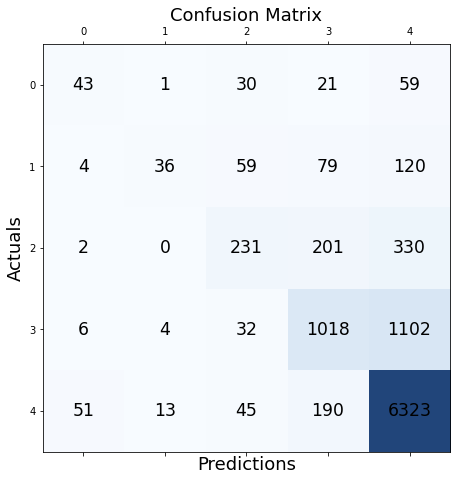

F1 Score for classes:
1.0 : 0.33076923076923076
2.0 : 0.20454545454545453
3.0 : 0.3979328165374677
4.0 : 0.5546172704985018
5.0 : 0.8687826325913712
Time Taken: 0:00:18.122185


In [38]:
##Testing accuracy on train dataset
t4 = datetime.datetime.now()
_, _ = nb.predict(data['reviewText'][0:10000], data['overall'][0:10000])
print('Time Taken:',datetime.datetime.now() - t4)

In [39]:
##Reading Test data 
test_data = read_it(test_path)

Accuracy:  60.57857142857143 %


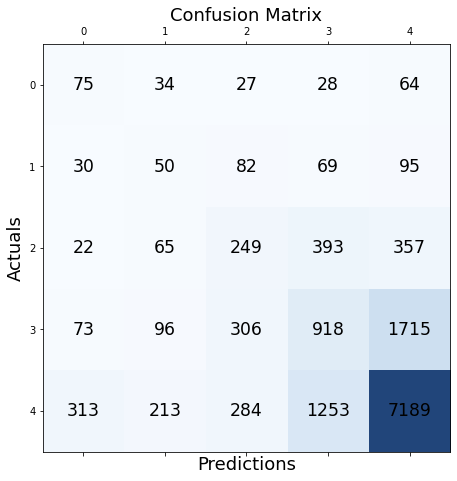

F1 Score for classes:
1.0 : 0.20242914979757085
2.0 : 0.12755102040816324
3.0 : 0.24483775811209443
4.0 : 0.3182527301092044
5.0 : 0.7700299914310196
0:00:25.160840


In [28]:
##Testing accuracy on test dataset
t5 = datetime.datetime.now()
_, _ = nb.predict(test_data['reviewText'], test_data['overall'])
print('Time Taken:',datetime.datetime.now() - t5)

Accuracy: 20.032


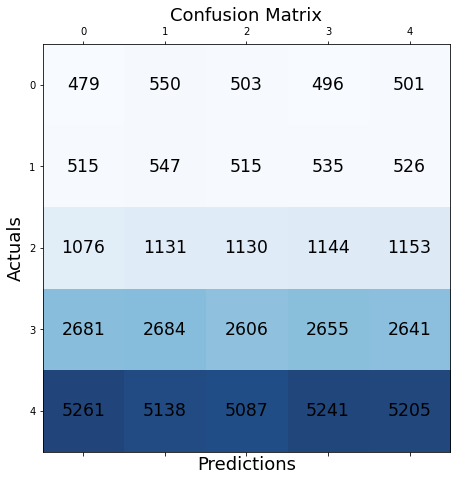

F1 Score for classes:
1.0 : 0.07638944262817957
2.0 : 0.08622320302648172
3.0 : 0.1460420032310178
4.0 : 0.2275259233867512
5.0 : 0.28950442182546304
0:00:00.369976


In [29]:
##Using Random Predictions
t6 = datetime.datetime.now()
_ = nb.random_prediction(data['reviewText'], data['overall'])
print(datetime.datetime.now() - t6)

{1.0: 322796, 2.0: 462949, 3.0: 1158958, 4.0: 2837186, 5.0: 4864005}
Most Occurring label: 5.0
Accuracy: 66.08571428571429


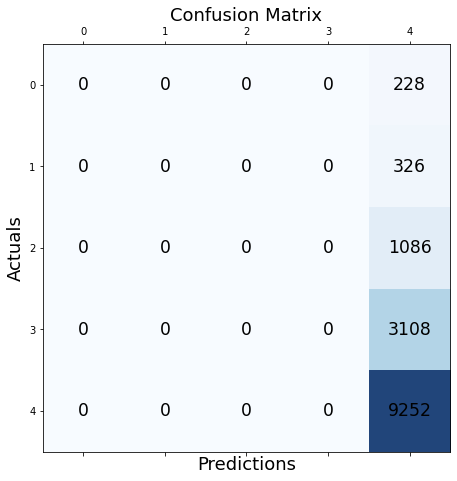

F1 Score for classes:
1.0 : 0
2.0 : 0
3.0 : 0
4.0 : 0
5.0 : 0.7958025116119043


In [36]:
##Using Majority as prediction
_ = nb.majority_prediction(test_data['reviewText'], test_data['overall'], docs_in_class)

[[2], [2], [2]]
